# 1 Loading the Data

the data are extracted from the acts of the European Parliament.
The corpus includes versions in 21 European languages.<br>
The data can be downloaded here  [here](https://www.statmt.org/europarl/#:~:text=starting%20with%20%22%3C%22)

In [32]:
# Import pandas packages
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.metrics import classification_report

In [5]:
# Import pandas packages
import pandas as pd
def readData(language):
    data_language = pd.read_csv("data\\"+language+".txt", sep="\r")
    data_language['language']=language
    #pick 20 000 rows rendom for every language
    return data_language.sample(n=8000,random_state=5)


In [6]:
data_english=readData("english")
data_spanish=readData("spanish")
data_french=readData("french")
data_italian=readData("italian")
data_german=readData("german")

In [7]:
#concat all the languages into one dataframe
data = pd.concat([data_english,data_spanish,data_french,data_italian,data_german],ignore_index=True)
#shuffle the data and reset the idex
data = data.sample(frac=1,random_state=5).reset_index(drop=True)
data.head(10)

,sentence,language
0,"Malgré tout, je pense qu'il s'agit d'un succès...",french
1,La possibilità di stipulare contratti via Inte...,italian
2,"Monsieur le Président, cette semaine, nous avo...",french
3,Wir hoffen auf eine Verbesserung.,german
4,Se advirtió a los soldados americanos de la KF...,spanish
5,"En effet, le sport professionnel est devenu un...",french
6,Thank you very much.,english
7,Entre los Estados miembros existe una clara di...,spanish
8,Le persone con cui abbiamo parlato nel corso d...,italian
9,There clearly is a problem and it is one that ...,english


# 2 Data pre-processing
Removing noise from data : 
- remove punctuations : [!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]
- remove digits 
- remove uppercase

In [8]:
def removeNoise(data):
    data["sentence"]=data["sentence"].str.replace('[0-9]', ' ',regex=True)
    data["sentence"]=data["sentence"].str.replace('['+string.punctuation+']', ' ',regex=True)
    data["sentence"]=data["sentence"].str.lower()
    return data
removeNoise(data.head(10).copy())
    

,sentence,language
0,malgré tout je pense qu il s agit d un succès...,french
1,la possibilità di stipulare contratti via inte...,italian
2,monsieur le président cette semaine nous avo...,french
3,wir hoffen auf eine verbesserung,german
4,se advirtió a los soldados americanos de la kf...,spanish
5,en effet le sport professionnel est devenu un...,french
6,thank you very much,english
7,entre los estados miembros existe una clara di...,spanish
8,le persone con cui abbiamo parlato nel corso d...,italian
9,there clearly is a problem and it is one that ...,english


# 3 splitting Data into Train and Test sets 

In [9]:
X,y =data["sentence"],data["language"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)


# 4 Vetorizer  and Model fitting
## TF-IDF vs Count Vectorizer

We initially wanted to compare the two transformers **Count Vectorizers** and **TF-IDF** .we test them with
the estimator **logistic regression** which is widely used to deal with classification issues

In [10]:
#Count Vectorizers with LogisticRegression
count_vectorizer = CountVectorizer( analyzer='word')
model_count_vectorizer = Pipeline([('vectorizer',count_vectorizer),('clf',LogisticRegression(max_iter=500))])

model_count_vectorizer.fit(X_train,y_train)
accuracyScore= metrics.accuracy_score(y_test,model_count_vectorizer.predict(X_test))
print("accuracy_score for countVectorizer : " , accuracyScore)

accuracy_score for countVectorizer :  0.99625


In [11]:
#TF-IDF with LogisticRegression
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,1),analyzer='word')
model_tf_idf = Pipeline([('vectorizer',tf_idf_vectorizer),('clf',LogisticRegression(max_iter=500))])

model_tf_idf.fit(X_train,y_train)
accuracyScore = metrics.accuracy_score(y_test,model_tf_idf.predict(X_test))
print("accuracy_score for TF-IDF Vectorizer : " , accuracyScore)

accuracy_score for TF-IDF Vectorizer :  0.99625


#### so like we see , we have a great accuracy score for both vectorizers with  a slight difference  for TF-IDF 99,6% vs 99,5% for countVectorizer 

so we will continue using the **TF_IDF** in the next sections


.

## Analyzer Char  vs  Word

We will compare the two Analyzer **Char** and **word** .we test them with
the estimator **logistic regression** and the **TF-IDF** Vectorizer

In [12]:
vectorizer = TfidfVectorizer(ngram_range=(1,1))
model= make_pipeline(vectorizer,LogisticRegression(max_iter=500))


In [13]:
#use the gridSearchCV to facilitate the test
params={'tfidfvectorizer__analyzer':["word","char"]}
grid = GridSearchCV(model,param_grid=params)
grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'tfidfvectorizer__analyzer': ['word', 'char']})

In [14]:
#display the resultat of comparaison word vs char 
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("Analyzer")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
Analyzer,,,,
word,{'tfidfvectorizer__analyzer': 'word'},1,0.995813,0.000673
char,{'tfidfvectorizer__analyzer': 'char'},2,0.967656,0.001269


**so like we see , we have again a  great accuracy score for both char and word which is beter by 3% . which surpise me because  knowing that all languages here have in common almost the same alphabetic and the main difference is how they appear in the word so I thought that char will have better accurarcy**

we will continue using the **word Analyzer** in the next sections


.

## ngram 1-gram 2-gram or  3-gram 

We will compare the two ngram modeling from **1-gram** to **3-gram** .we test them with
the estimator **logistic regression** and the **TF-IDF** Vectorizer and **word Analyzer**

In [15]:
vectorizer = TfidfVectorizer(analyzer="word")
model= make_pipeline(vectorizer,LogisticRegression(max_iter=500))

#use the gridSearchCV to facilitate the test
params={'tfidfvectorizer__ngram_range': ((1, 1), (1, 2),(1, 3))}
grid = GridSearchCV(model,param_grid=params)
grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'tfidfvectorizer__ngram_range': ((1, 1), (1, 2),
                                                          (1, 3))})

In [16]:
#display the resultat of comparaison 1-gram , 2-gram 3-gram
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("Analyzer")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
Analyzer,,,,
"(1, 2)","{'tfidfvectorizer__ngram_range': (1, 2)}",1,0.995875,0.000660
"(1, 1)","{'tfidfvectorizer__ngram_range': (1, 1)}",2,0.995813,0.000673
"(1, 3)","{'tfidfvectorizer__ngram_range': (1, 3)}",3,0.995781,0.000765


Prediction accuracy of 99.5875% was achieved on test data using a model trained with 2-gram Word logistic regression Model<br>
Prediction accuracy of 99.5813% was achieved on test data using a model trained with 1-gram Word logistic regression Model<br>
Prediction accuracy of 99.5781% was achieved on test data using a model trained with 3-gram Word logistic regression Model<br>



In [17]:
vectorizer = TfidfVectorizer(analyzer="word")
model= make_pipeline(vectorizer,LogisticRegression(max_iter=500))

#use the gridSearchCV to facilitate the test
params={'tfidfvectorizer__ngram_range': ((1, 1), (1, 2),(1, 3)),'tfidfvectorizer__analyzer':["word","char"]}
grid = GridSearchCV(model,param_grid=params)
grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'tfidfvectorizer__analyzer': ['word', 'char'],
                         'tfidfvectorizer__ngram_range': ((1, 1), (1, 2),
                                                          (1, 3))})

In [18]:
#display the resultat of comparaison 1-gram , 2-gram 3-gram
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("Analyzer|n_gram")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
Analyzer|n_gram,,,,
"char_(1, 3)","{'tfidfvectorizer__analyzer': 'char', 'tfidfve...",1,0.996438,0.000468
"word_(1, 2)","{'tfidfvectorizer__analyzer': 'word', 'tfidfve...",2,0.995875,0.000660
"word_(1, 1)","{'tfidfvectorizer__analyzer': 'word', 'tfidfve...",3,0.995813,0.000673
"word_(1, 3)","{'tfidfvectorizer__analyzer': 'word', 'tfidfve...",4,0.995781,0.000765
"char_(1, 2)","{'tfidfvectorizer__analyzer': 'char', 'tfidfve...",5,0.994563,0.000636
"char_(1, 1)","{'tfidfvectorizer__analyzer': 'char', 'tfidfve...",6,0.967656,0.001269


**after we decide to test all Vectorizer options together, 
we finded that our model performs even better with analyzer = char and n_gram = (1,3)**

In the next chapter, we will see all the metrics and we will try to analyse them

.

# 5 Analysis and Comparison of all the models

In [30]:
y_predicted= grid.predict(X_test)
accuracyScore = metrics.accuracy_score(y_test,y_predicted)

In [41]:
matrix = metrics.confusion_matrix(y_test,y_predicted)


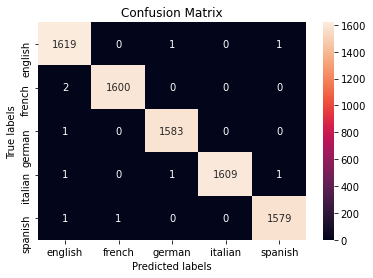

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(grid.classes_); 
ax.yaxis.set_ticklabels(grid.classes_);

**like we see ,our model perfrmance is greate , we have only**  :
- 2 french strings were missclassified as english
- 1 german strings were missclassified as english
- 1 italien strings were missclassified as english
- 1 spanish strings were missclassified as english
- 1 english strings were missclassified as german
- 1 english strings were missclassified as spanish


# 6 SAVE and LOAD the model

In [20]:
#first we will save our best model to use him later
bestparams=grid.best_params_
bestModel=grid.best_estimator_
bestModel.fit(X_test,y_test)


array([[0.08116446, 0.13281215, 0.10479645, 0.38451908, 0.29670786]])

In [22]:
import pickle
saveModel = open('myModel.pckl','wb')
pickle.dump(bestModel,saveModel)
saveModel.close()


In [23]:
import string
import pickle
import pandas as pd
#load saved model
saveModel =open('myModel.pckl','rb')
bestModel = pickle.load(saveModel)
saveModel.close()

# 7 Graphical interface 

In [26]:
import tkinter as tk



def languageDetector(inputText):
    import string
    import pickle
    global bestModel
    global resultatFrame

    
    #remove noise
    inputText =inputText.replace('[0-9]', ' ')
    inputText=inputText.replace('['+string.punctuation+']', ' ')
    inputText=inputText.lower()
    
    #predection
    predectedLanguage = bestModel.predict([inputText])
    probability = bestModel.predict_proba([inputText])
    allProb= pd.DataFrame(probability, bestModel=model.classes_)
    
    #dispaly resultat
    
    for child in resultatFrame.winfo_children():
        child.destroy()

    
    predResult_label = tk.Label(resultatFrame,fg="#12183d",bg='#f5f5f5',font=("Arial", 15),
                           padx=50,pady=50,
                           text="this text is written in "+predectedLanguage)
    
    predResult_label.pack()

    resultatFrame.pack()
    
    
#load saved model
saveModel =open('myModel.pckl','rb')
bestModel = pickle.load(saveModel)
saveModel.close()    

#windows
app = tk.Tk()
app.title("Language Detector")
app.minsize(1020, 700)
width_value = app.winfo_screenwidth()
height_value = app.winfo_screenheight()
app.geometry(str(width_value) + "x" + str(height_value))
app.configure(bg='#f5f5f5')


#frames
middleFrame = tk.Frame(app, background='#f5f5f5', width=700, height=height_value)

title_label = tk.Label(middleFrame,fg="#12183d",bg='#f5f5f5',font=("Arial", 15),padx=50,pady=50, text="Welcome to our Language Detector \n Our model support 5 languages (en,es,fr,it,de)")
title_label.pack()

# Create text widget and specify size.
textArea = tk.Text(middleFrame, height = 10, width = 70)
textArea.pack()

# Create button for detect text.
btnDetect = tk.Button(middleFrame, text = "Detect",bg="#6378ff",fg="white",font=("Arial", 15),pady=5,width = 50 ,command= lambda: languageDetector(textArea.get("1.0",'end-1c')))
btnDetect.pack(pady=10)
#resultat frame
resultatFrame =tk.Frame(middleFrame)



middleFrame.pack()


app.mainloop()


